# ***1. Importación de librerías y datos***

In [96]:
#Librerías
import pandas as pd
import numpy as np

In [97]:
# Cargar los conjuntos de datos
datanum = pd.read_csv("../Data/numeric_data.csv")
datacat = pd.read_csv("../Data/categorical_data.csv")
datacat = datacat.astype('category')

In [98]:
# Visualizamos información sobre los datos
print("Datos numéricos:")
datanum.info()

Datos numéricos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Age                                                   2556 non-null   float64
 1   Work/Study Hours                                      2556 non-null   float64
 2   Depression                                            2556 non-null   int64  
 3   Working Professional or Student_Working Professional  2556 non-null   int64  
 4   Have you ever had suicidal thoughts ?_Yes             2556 non-null   int64  
 5   Dietary Habits_Healthy                                2556 non-null   int64  
 6   Dietary Habits_Moderate                               2556 non-null   int64  
 7   Dietary Habits_Unhealthy                              2556 non-null   int64  
 8   Degree_B.Arch                            

In [99]:
# Visualizamos información sobre los datos
print("Datos categóricos:")
datacat.info()

Datos categóricos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Age                                    2556 non-null   category
 1   Working Professional or Student        2556 non-null   category
 2   Dietary Habits                         2556 non-null   category
 3   Degree                                 2556 non-null   category
 4   Have you ever had suicidal thoughts ?  2556 non-null   category
 5   Work/Study Hours                       2556 non-null   category
 6   Financial Stress                       2556 non-null   category
 7   Depression                             2556 non-null   category
 8   Job/Study Satisfaction                 2556 non-null   category
 9   Work/Academic Pressure                 2556 non-null   category
dtypes: category(10)
memory usage: 27.9 KB


In [100]:
# Función para división de datos
from sklearn.model_selection import train_test_split

def dividir_datos(dataset, target_column):
    # División de los datos en entrenamiento y prueba
    X = dataset.drop(target_column, axis=1)
    Y = dataset[target_column]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
    
    return X_train, X_test, Y_train, Y_test

In [101]:
# Función para balancear datos numéricos con SMOTE
from imblearn.over_sampling import SMOTE

def balanceoNum(X_train, Y_train):
    # Aplicar SMOTE al conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_bal, Y_train_bal = smote.fit_resample(X_train, Y_train)

    Y_train_bal.value_counts().plot(kind='barh')
    
    return X_train_bal, Y_train_bal

In [102]:
import pickle

# Cargar el LabelEncoder desde el archivo
with open('../DataPreparation/labelencoder.pkl', 'rb') as file:
    labelencoder = pickle.load(file)

# Aplicar el LabelEncoder cargado a una columna
# Suponiendo que tienes una columna llamada "Depression" que necesita ser codificada
datacat["Depression"] = labelencoder.transform(datacat["Depression"])

# Muestra una muestra de los datos transformados
datacat.sample(5)


,Age,Working Professional or Student,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression,Job/Study Satisfaction,Work/Academic Pressure
352,"[39.0, 49.5)",Working Professional,Unhealthy,B.Arch,Yes,"[9.0, 12.012)",5,0,3.0,2.0
54,"[39.0, 49.5)",Working Professional,Moderate,MBBS,Yes,"[9.0, 12.012)",3,0,3.0,5.0
1661,"[39.0, 49.5)",Working Professional,Healthy,M.Pharm,Yes,"[0.0, 3.0)",4,0,2.0,4.0
1658,"[28.5, 39.0)",Working Professional,Unhealthy,MSc,No,"[0.0, 3.0)",5,0,3.0,2.0
1581,"[18.0, 28.5)",Working Professional,Moderate,B.Com,No,"[3.0, 6.0)",3,0,3.0,1.0


In [103]:
# Función para balancear datos categóricos con SMOTENC
from imblearn.over_sampling import SMOTENC

def balanceoCat(X_train, Y_train):
    # Asegurarse de que todas las columnas sean de tipo 'category'
    for col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
    
    # Obtener los índices de las columnas categóricas
    categorical_indices = list(range(X_train.shape[1]))
    
    # Agregar una columna numérica temporal para permitir que SMOTENC funcione
    X_train['temp_numeric'] = 0  # Columna numérica temporal
    
    # Ajustar los índices de las columnas categóricas para excluir la columna temporal
    categorical_indices = list(range(X_train.shape[1] - 1))
    smote = SMOTENC(categorical_features=categorical_indices, random_state=42, k_neighbors=2)
    X_train_bal, Y_train_bal = smote.fit_resample(X_train, Y_train)
    
    # Eliminar la columna numérica temporal después del balanceo
    X_train_bal = X_train_bal.drop('temp_numeric', axis=1)
    
    Y_train_bal.value_counts().plot(kind='barh')
    
    return X_train_bal, Y_train_bal


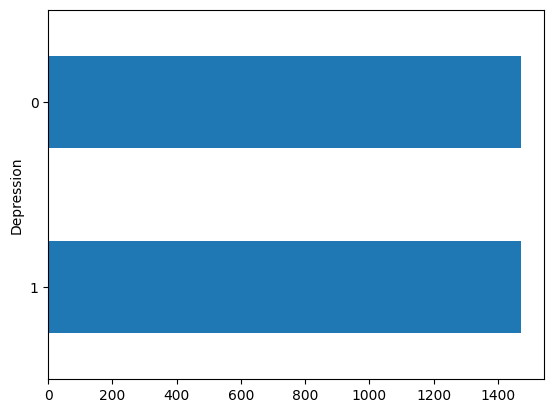

In [104]:
# Dividir y balancear los conjuntos de datos numéricos
X_num_train, X_num_test, Y_num_train, Y_num_test = dividir_datos(datanum, 'Depression')
X_num_train_bal, Y_num_train_bal = balanceoNum(X_num_train, Y_num_train)

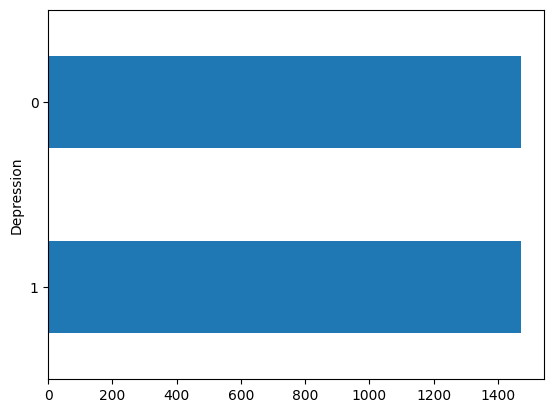

In [105]:
# Dividir y balancear los conjuntos de datos categóricos
X_cat_train, X_cat_test, Y_cat_train, Y_cat_test = dividir_datos(datacat, 'Depression')
X_cat_train_bal, Y_cat_train_bal = balanceoCat(X_cat_train, Y_cat_train)

In [106]:
#Librerías para clasificación
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [107]:
# Lista de modelos
models_num = {
    "Support Vector Classifier": SVC(kernel='linear', random_state=42),
    "Artificial Neural Network": MLPClassifier(activation="relu", hidden_layer_sizes=(26), learning_rate='constant', learning_rate_init=0.02, momentum= 0.3, max_iter=500, verbose=False, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, max_depth=5,random_state=42),
}

models_cat = {
    "Decision Tree": DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, max_depth=5,random_state=42),
}

In [112]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Datos de ejemplo para entrenamiento, reemplaza con tu conjunto de datos completo de entrenamiento
X = X_cat_train_bal  # o los datos que consideres finales para graficar
y = Y_cat_train_bal

# Entrenar el modelo de árbol de decisión en todos los datos de entrenamiento
model_dt = DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, max_depth=3, random_state=42)
model_dt.fit(X, y)

# Graficar el árbol de decisión
plt.figure(figsize=(20, 20))
plot_tree(model_dt, 
          feature_names=X.columns,  # Ajusta si tus columnas cambiaron tras el preprocesamiento
          class_names=labelencoder.classes_,  # Asegúrate de que labelencoder esté definido y ajustado
          rounded=True, 
          filled=True)
plt.show()


ValueError: could not convert string to float: '[18.0, 28.5)'

In [109]:
# Configuración de validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Función para realizar validación cruzada con cross_validate
def crossValidateModels(models, X, y, cv):
    results = {}
    for model_name, model in models.items():
        # Evaluar el modelo con cross_validate
        scores = cross_validate(model, X, y, cv=cv, scoring='accuracy', return_train_score=True)
        results[model_name] = {
            "Train Score Mean": scores['train_score'].mean(),
            "Test Score Mean": scores['test_score'].mean(),
            "Fit Time Mean": scores['fit_time'].mean(),
            "Score Time Mean": scores['score_time'].mean()
        }

        print(f"Modelo: {model_name}")
        print(f"   - Precisión media (entrenamiento): {scores['train_score'].mean():.2f}")
        print(f"   - Precisión media (validación): {scores['test_score'].mean():.2f}")
        print(f"   - Tiempo de ajuste medio: {scores['fit_time'].mean():.4f} segundos")
        print(f"   - Tiempo de evaluación medio: {scores['score_time'].mean():.4f} segundos\n")
    return results

In [110]:
print("Modelos para datos numéricos:")
resultsNum = crossValidateModels(models_num, X_num_train_bal, Y_num_train_bal, cv)

Modelos para datos numéricos:
Modelo: Support Vector Classifier
   - Precisión media (entrenamiento): 0.98
   - Precisión media (validación): 0.97
   - Tiempo de ajuste medio: 0.0306 segundos
   - Tiempo de evaluación medio: 0.0030 segundos

Modelo: Artificial Neural Network
   - Precisión media (entrenamiento): 1.00
   - Precisión media (validación): 0.97
   - Tiempo de ajuste medio: 0.1445 segundos
   - Tiempo de evaluación medio: 0.0013 segundos

Modelo: K-Nearest Neighbors
   - Precisión media (entrenamiento): 0.93
   - Precisión media (validación): 0.87
   - Tiempo de ajuste medio: 0.0034 segundos
   - Tiempo de evaluación medio: 0.0095 segundos

Modelo: Logistic Regression
   - Precisión media (entrenamiento): 0.98
   - Precisión media (validación): 0.98
   - Tiempo de ajuste medio: 0.0082 segundos
   - Tiempo de evaluación medio: 0.0013 segundos

Modelo: Decision Tree
   - Precisión media (entrenamiento): 0.90
   - Precisión media (validación): 0.88
   - Tiempo de ajuste medio: 

In [111]:
t("Modelos para datos numéricos:")
resultsNum = crossValidateModels(models_cat, X_num_train_bal, Y_num_train_bal, cv)

NameError: name 't' is not defined